In [1]:
import numpy as np
from data import text_data
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/satya-
[nltk_data]     tt0492/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/satya-
[nltk_data]     tt0492/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
raw_text = text_data
raw_text = [x.split() for x in raw_text]

In [4]:
stop_words = set(stopwords.words('english'))

# Function to remove stopwords and tokenize sentences
def preprocess_sentences(sentences):
    processed_sentences = []
    for sentence in sentences:
        # Tokenize the sentence into words
        tokens = word_tokenize(sentence.lower())  # Convert to lowercase to maintain consistency
        # Remove stopwords and non-alphabetic words
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        processed_sentences.append(filtered_tokens)
    return processed_sentences

# Process the sentences
processed_data = preprocess_sentences(text_data)

In [5]:
raw_text = processed_data

In [6]:
vocabulary = []
for sentence in raw_text:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [7]:
len(word2idx)

368

In [8]:
vocabulary_size

368

In [27]:
window_size = 5
context_size = 2
data = []
for sentence in raw_text:
    for i in range(window_size//2,len(sentence)):
        d = []
        for j in range(context_size):
            d.append(sentence[i-j-1])
            if i + j + 1 < len(sentence):
                d.append(sentence[i+j+1])
        if(len(d) == 2 * context_size):
            data.append((d,sentence[i]))
data[:10]

[(['brown', 'jumped', 'quick', 'lazy'], 'fox'),
 (['fox', 'lazy', 'brown', 'dog'], 'jumped'),
 (['sea', 'sea', 'sells', 'shore'], 'shells'),
 (['shells', 'shore', 'sea', 'every'], 'sea'),
 (['sea', 'every', 'shells', 'morning'], 'shore'),
 (['hand', 'two', 'bird', 'bush'], 'worth'),
 (['loved', 'never', 'better', 'loved'], 'lost'),
 (['speak', 'words', 'actions', 'words'], 'louder'),
 (['louder', 'words', 'speak', 'still'], 'words'),
 (['words', 'still', 'louder', 'matter'], 'words')]

In [28]:
len(data)

190

In [30]:
data[0][0]

['brown', 'jumped', 'quick', 'lazy']

In [31]:
# Convert to pairs of (target:context) to feed to the skipgram model
pair_data = []
for window in data:
    for word in window[0]:
        pair_data.append((window[1],word))

In [32]:
pair_data[:10]

[('fox', 'brown'),
 ('fox', 'jumped'),
 ('fox', 'quick'),
 ('fox', 'lazy'),
 ('jumped', 'fox'),
 ('jumped', 'lazy'),
 ('jumped', 'brown'),
 ('jumped', 'dog'),
 ('shells', 'sea'),
 ('shells', 'sea')]

In [54]:
class SkipGram(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super(SkipGram,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_size)
        self.linear1 = nn.Linear(embedding_size,embedding_size)
        self.linear2 = nn.Linear(embedding_size, vocab_size)
    
    def forward(self,target_word):
        embeds = self.embedding(target_word)
        out = nn.functional.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out

In [55]:
model = SkipGram(embedding_size=50,vocab_size=vocabulary_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
losses = []

In [56]:
for epochs in range(501):
    total_loss = 0
    for target, context in pair_data:

        target_tensor = torch.tensor([word2idx[target]], dtype=torch.long)
        context_tensor = torch.tensor([word2idx[context]], dtype=torch.long)

        optimizer.zero_grad()

        output = model(target_tensor)

        loss = criterion(output, context_tensor)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epochs % 50 == 0:
        print(f"Epoch: {epochs} - Loss: {total_loss}")
    losses.append(total_loss)

print(losses)

Epoch: 0 - Loss: 4619.196750879288
Epoch: 50 - Loss: 1303.3847761154175
Epoch: 100 - Loss: 1279.99902510643
Epoch: 150 - Loss: 1268.8574313521385
Epoch: 200 - Loss: 1260.6253233253956
Epoch: 250 - Loss: 1255.7765884399414
Epoch: 300 - Loss: 1279.6985660120845
Epoch: 350 - Loss: 1246.1362289786339
Epoch: 400 - Loss: 1245.7463073134422
Epoch: 450 - Loss: 1252.7203132510185
Epoch: 500 - Loss: 1242.4148176908493
[4619.196750879288, 3618.3611092567444, 2706.165145277977, 2075.878318205476, 1752.7596339285374, 1584.5433552265167, 1507.2558652758598, 1448.9355469942093, 1424.6740373969078, 1402.4785283207893, 1391.0486513972282, 1385.4356659054756, 1370.1911687850952, 1365.6161012649536, 1359.4846929907799, 1353.777476131916, 1350.1305115818977, 1346.5674928426743, 1345.1127843856812, 1342.966360092163, 1340.524541348219, 1344.9293575882912, 1349.1879240572453, 1333.9566460847855, 1331.1497097611427, 1330.292034804821, 1331.5398541986942, 1328.4790769219398, 1325.305132895708, 1324.0304204225

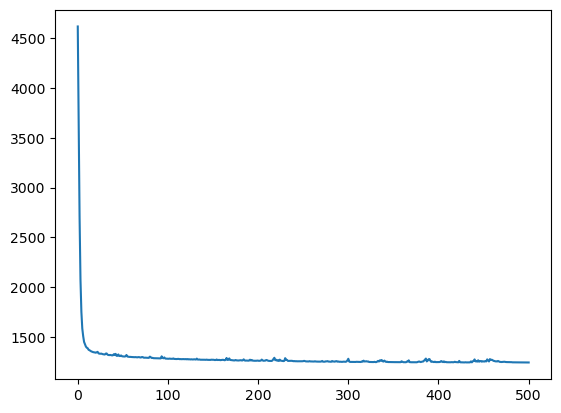

In [57]:
plt.plot(losses)

In [58]:
vocabulary_size

368

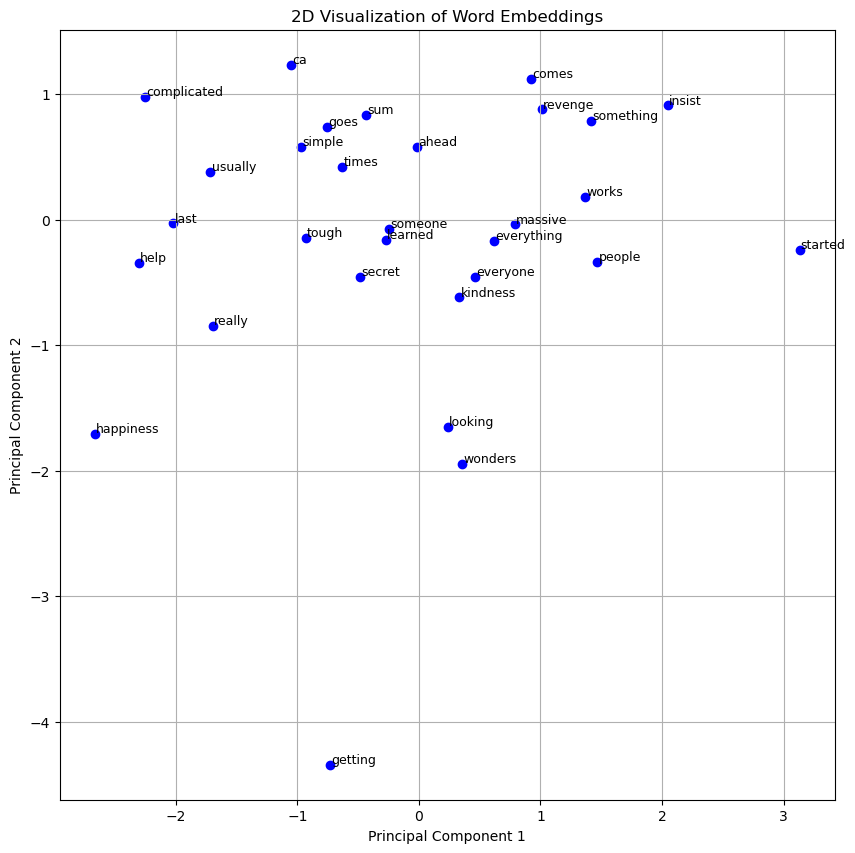

In [59]:
from sklearn.decomposition import PCA

embeddings = model.embedding.weight.data  # Shape: (vocab_size, embedding_dim)

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)  # Shape: (vocab_size, 2)

words = list(word2idx.keys())

plt.figure(figsize=(10, 10))
for i, word in enumerate(words[150:180]):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, marker='o', color='blue')
    plt.text(x + 0.01, y + 0.01, word, fontsize=9)  # Offset text slightly for visibility

plt.title("2D Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


Note- The loss is obviously very very bad, it needs more proper data to find the context words from the target words on a good dataset.  
This is just an internal implementations of how skipgram works